In [ ]:
#  Setup & load data



# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from os import pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

print("Imports loaded")


Imports loaded


In [ ]:
data_path = 'CVD_cleaned.csv'
df = pd.read_csv(data_path)

print("Dataset loaded. Shape:", df.shape)
display(df.head())
print("\nColumns in the dataset:")
print(df.columns.tolist())

Dataset loaded. Shape: (308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0



Columns in the dataset:
['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  int64  
 12  Weight_(kg)                   308854 non-nul

## 1. Inspect dataset, find/confirm target column

In [ ]:
# Cell 1: Inspect dataset and detect target column
print("Columns:\n", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

Columns:
 ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

Data types:
 General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64
Fruit_Consumption        

In [ ]:
possible_targets = ['Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression']
target_col = None


for c in df.columns:
  if c in possible_targets:
    target_col = c
    break

if target_col is None:
   target_col = df.columns[-1]

print("Using target column ->",target_col)

Using target column -> Checkup


In [ ]:
X=df.drop(columns=[target_col]).copy()
y=df[target_col].copy()


In [ ]:
#Quick handle the data
print("Target value counts:")
display(y.value_counts())

Target value counts:


,count
Checkup,
Within the past year,239371
Within the past 2 years,37213
Within the past 5 years,17442
5 or more years ago,13421
Never,1407


In [ ]:
# Simple preprocessing pipeline for numerical futures impute mean scale
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical columns:",num_cols)
print("Categorical columns:",cat_cols)

Numerical columns: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
Categorical columns: ['General_Health', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']


In [ ]:
# For simplicity convert categorical bools to int
for c in cat_cols:
  X[c]=X[c].astype('category').cat.codes

# If any non numeric remain coerce
X= X.apply(pd.to_numeric, errors='coerce')

# Impute missing values (mean) for any numeric columns that have Nans
if X.isnull().any().any():
  X=X.fillna(X.mean())


print("\n After reprocessing any missing?",X.isnull().any().any())


 After reprocessing any missing? False


#  1.	Split dataset with 8:2 ratio for train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:',X_train.shape,'Test shape:',X_test.shape)

Train shape: (247083, 18) Test shape: (61771, 18)


# 2.	Apply Random forest and Logistic regression for building model (use X_train, Y-train)

In [ ]:
# Define pipelines (Scaling inside pipeline)
models = {
    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())]),
}

# Run and evaluate models(Initial)

results = {}
for name, pipe  in models.items():
  pipe.fit(X_train, y_train)
  preds = pipe.predict(X_test)
  acc = accuracy_score(y_test, preds)
  results[name] = {'model' : pipe, 'accuracy': acc, 'preds': preds}
  print(f"\n=== {name} ===\nAccuracy: {acc:.4f}")


=== Logistic Regression ===
Accuracy: 0.7757

=== Random Forest ===
Accuracy: 0.7730


#3.	Test the models one by one on unseen data (X_test)  

#4.	Display accuracy score, classification report and confusion matrix for each of models

In [ ]:
# Test models and display metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Testing models on unseen data (X_test):\n")

for name, info in results.items():
    model = info['model']
    preds = info['preds'] # Use the predictions already stored in the results dictionary

    print(f"=== {name} ===")

    # Accuracy Score
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print("-" * 30)

Testing models on unseen data (X_test):

=== Logistic Regression ===
Accuracy: 0.7757

Classification Report:
                         precision    recall  f1-score   support

    5 or more years ago       0.50      0.00      0.00      2634
                  Never       0.00      0.00      0.00       287
Within the past 2 years       0.00      0.00      0.00      7433
Within the past 5 years       0.00      0.00      0.00      3500
   Within the past year       0.78      1.00      0.87     47917

               accuracy                           0.78     61771
              macro avg       0.26      0.20      0.17     61771
           weighted avg       0.62      0.78      0.68     61771


Confusion Matrix:
[[    1     0     0     0  2633]
 [    0     0     0     0   287]
 [    0     0     0     0  7433]
 [    0     0     0     0  3500]
 [    1     0     0     0 47916]]
------------------------------
=== Random Forest ===
Accuracy: 0.7730

Classification Report:
                       

#5.	Plot the comparison of the accuracies as a bar chart

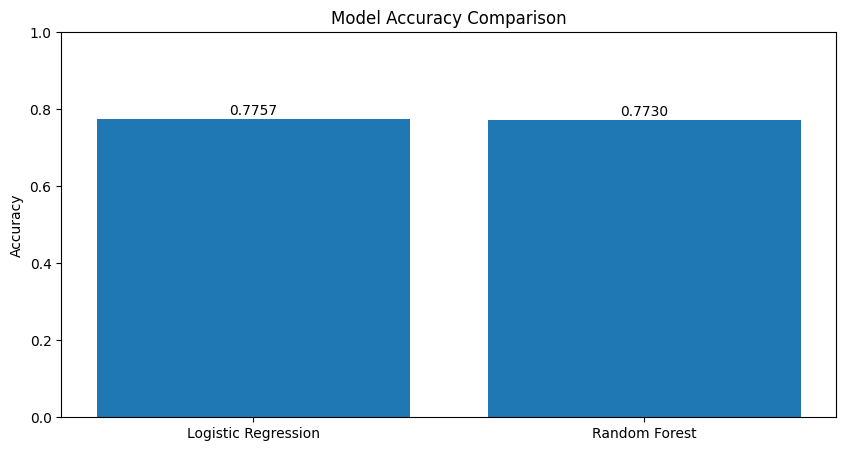

In [ ]:
# Accuracy comparison bar chart
names= list(results.keys())
accs = [results[n]['accuracy'] for n in names]
plt.figure(figsize=(10,5))
plt.bar(names,accs)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accs):
  plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

#6.	Apply randomised grid search to tune the hyper parameters

In [ ]:
#Hyperparameter tuning with RandomizedSearchCV
from scipy.stats import randint, uniform
#tune RandomForest
rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3,20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 15),
}
rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=10, cv=2, scoring='accuracy',random_state=42,n_jobs=-1)
rf_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_search.best_params_)
best_rf = rf_search.best_estimator_
rf_preds = best_rf.predict(X_test)
print('RandomForest test accuracy after tuning',accuracy_score(y_test,rf_preds))
results['Random Forest Tuned'] = {'model': best_rf, 'accuracy': accuracy_score(y_test, rf_preds), 'preds': rf_preds}


Best parameters for Random Forest: {'max_depth': 13, 'min_samples_leaf': 11, 'min_samples_split': 9, 'n_estimators': 166}
RandomForest test accuracy after tuning 0.7757038092308689


In [ ]:
#Hyperparameter tuning with RandomizedSearchCV for Logistic Regression
from scipy.stats import uniform

#Tune Logistic Regression (on a scaled pipeline)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
lr_param_dist = {
    'clf__C': uniform(0.01, 10),
    'clf__penalty': ['l2', 'l1'],
    'clf__solver': ['liblinear', 'saga']
}

lr_search = RandomizedSearchCV(lr_pipe, lr_param_dist, n_iter=10, cv=2, scoring='accuracy',random_state=42,n_jobs=-1)
lr_search.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", lr_search.best_params_)
best_lr = lr_search.best_estimator_
lr_preds = best_lr.predict(X_test)
print('Logistic Regression test accuracy after tuning',accuracy_score(y_test,lr_preds))

# Save tuned results into results dict for a comparison
results['Logistic Regression Tuned'] = {'model': best_lr, 'accuracy': accuracy_score(y_test, lr_preds), 'preds': lr_preds}

Best parameters for Logistic Regression: {'clf__C': np.float64(3.7554011884736247), 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Logistic Regression test accuracy after tuning 0.7757038092308689


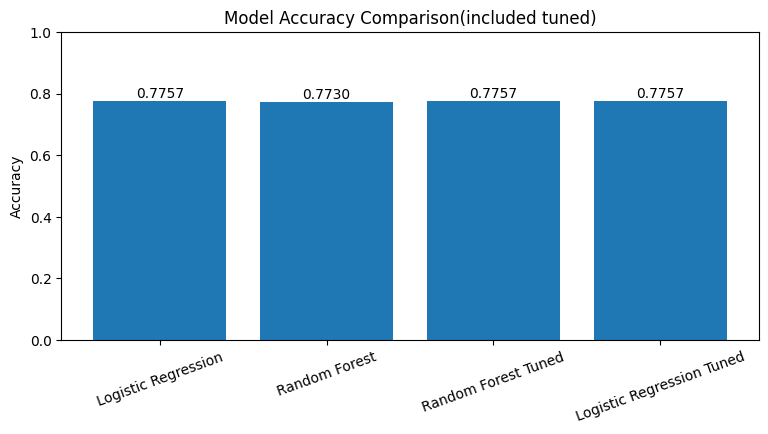

In [ ]:
# Updated accuracy comparison(Including tuned models)
names= list(results.keys())
accs = [results[n]['accuracy'] for n in names]
plt.figure(figsize=(9,4))
plt.bar(names,accs)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison(included tuned)')
for i, v in enumerate(accs):
  plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.xticks(rotation=20)
plt.show()

#7.	Predict and display the health status for a single input from the dataset resembling the working of an AI system

In [ ]:
#Single-row prediction demo
# We will pick a row from X _test as example and show predicted VS actual
example_idx = X_test.index[0]
example_row = X_test.loc[example_idx:example_idx]
print("Example index:",example_idx)
display(example_row)
print("Actual target:",y_test.loc[example_idx])

for name, info in results.items():
  try:
   pred = info['model'].predict(example_row)
   print(f"\n=== {name} ===\nPredicted target:",pred[0])
  except Exception as e:
   print(f"{name} prediction failed: {e}")


Example index: 302051


,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
302051,4,1,0,0,0,0,0,1,1,8,178,86.18,27.26,0,12,30,16,8


Actual target: Within the past year

=== Logistic Regression ===
Predicted target: Within the past year

=== Random Forest ===
Predicted target: Within the past year

=== Random Forest Tuned ===
Predicted target: Within the past year

=== Logistic Regression Tuned ===
Predicted target: Within the past year


## Notebook Summary

This notebook performs the following steps to build and evaluate classification models for predicting health checkup frequency:

1.  **Setup and Data Loading:**
    *   Imports necessary libraries for data manipulation, machine learning, and visualization (pandas, numpy, matplotlib, seaborn, scikit-learn).
    *   Loads the `CVD_cleaned.csv` dataset into a pandas DataFrame.

2.  **Data Inspection and Target Identification:**
    *   Inspects the dataset's shape, columns, data types, and checks for missing values.
    *   Identifies 'Checkup' as the target variable for prediction.

3.  **Data Preprocessing:**
    *   Separates features (X) and the target variable (y).
    *   Identifies numerical and categorical columns.
    *   Converts categorical columns to numerical representations using categorical codes.
    *   Coerces any remaining non-numeric values to NaN and imputes missing values with the mean of the respective columns.

4.  **Data Splitting:**
    *   Splits the preprocessed data into training and testing sets with an 80:20 ratio.

5.  **Model Building (Initial):**
    *   Defines pipelines for Logistic Regression and Random Forest classifiers, including StandardScaler for numerical feature scaling within the pipeline.
    *   Trains the initial Logistic Regression and Random Forest models on the training data.
    *   Evaluates the initial models on the test data and stores the results (model, accuracy, predictions) in a dictionary.

6.  **Model Testing and Evaluation:**
    *   Iterates through the trained models.
    *   Calculates and displays the accuracy score, classification report, and confusion matrix for each model on the test set.

7.  **Hyperparameter Tuning (Random Forest and Logistic Regression):**
    *   Uses `RandomizedSearchCV` to tune the hyperparameters of the Random Forest and Logistic Regression models.
    *   Defines hyperparameter distributions for each model.
    *   Performs the randomized search with cross-validation on the training data.
    *   Prints the best parameters found and the test accuracy of the tuned models.
    *   Saves the tuned models, their accuracies, and predictions in the `results` dictionary.

8.  **Accuracy Comparison Plot:**
    *   Generates a bar chart to visually compare the accuracy scores of all trained models (initial and tuned).

9.  **Single-Row Prediction Demo:**
    *   Selects a single row from the test set as an example.
    *   Displays the example row's features and its actual target value.
    *   Uses each of the trained models to predict the target for the example row and displays the predictions.